## Importing Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install tensorflow
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [ ]:
data_dir = "/content/drive/MyDrive/Indian"
#train_path = 'Images'
#test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [ ]:
#NUM_CATEGORIES = len(os.listdir(train_path))
#NUM_CATEGORIES


import os

# Correct path to the training data
train_path = os.path.join(data_dir, 'Images')

# Check if the path exists
if os.path.exists(train_path):
    NUM_CATEGORIES = len(os.listdir(train_path))
    print(NUM_CATEGORIES)
else:
    print(f"Directory {train_path} not found.")


59


In [ ]:
# Label Overview
classes = { 0:'Give Way',
            1:'No Entry',
            2:'One-way traffic',
            3:'One-way traffic',
            4:'No vehicels in both directions',
            5:'No Entry For Cycles',
            6:'No Entry For goods vehicles',
            7:'No Entry For Pedestrians',
            8:'No Entry For Bullock Carts',
            9:'No Entry For Hand Carts',
            10:'No Entry For Motor Vehicles',
            11:'Height Limit',
            12:'Weight Limit',
            13:'Axle Weight Limit',
            14:'Length Limit',
            15:'No Left Turn',
            16:'No Right Turn',
            17:'No Overtaking',
            18:'Maximum Speed Limit(90 km/h)',
            19:'Maximum Speed Limit(110 km/h)',
            20:'Horn Prohibited',
            21:'No Parking',
            22:'No Stopping',
            23:'Turn Left',
            24:'Turn right',
            25:'Steep descent',
            26:'Steep ascent',
            27:'Narrow road',
            28:'Narrow bridge',
            29:'Unprotected Quay',
            30:'Road Humo',
            31:'Dip',
            32:'Loose Gravel',
            33:'Falling Rocks',
            34:'Cattle',
            35:'CrossRoads',
            36:'Side road junction',
            37:'Side road junction',
            38:'Oblique Side road junction',
            39:'Oblique Side road junction',
            40:'T-Junction',
            41:'Y-Junction',
            42:'Staggered Side road junction',
            43:'Staggered Side road junction',
            44:'Roundabout',
            45:'Guarded level crossing ahead',
            46:'Unguarded level crossing ahead',
            47:'Level Crossing countdown marker',
            48:'Level Crossing countdown marker',
            49:'Level Crossing countdown marker',
            50:'Level Crossing countdown marker',
            51:'Parking',
            52:'Bus Stop',
            53:'First aid post',
            54:'Telephone',
            55:'Filling station',
            56:'Hotel',
            57:'Restaurant',
            58:'Refreshments'}



## Visualizing The Dataset

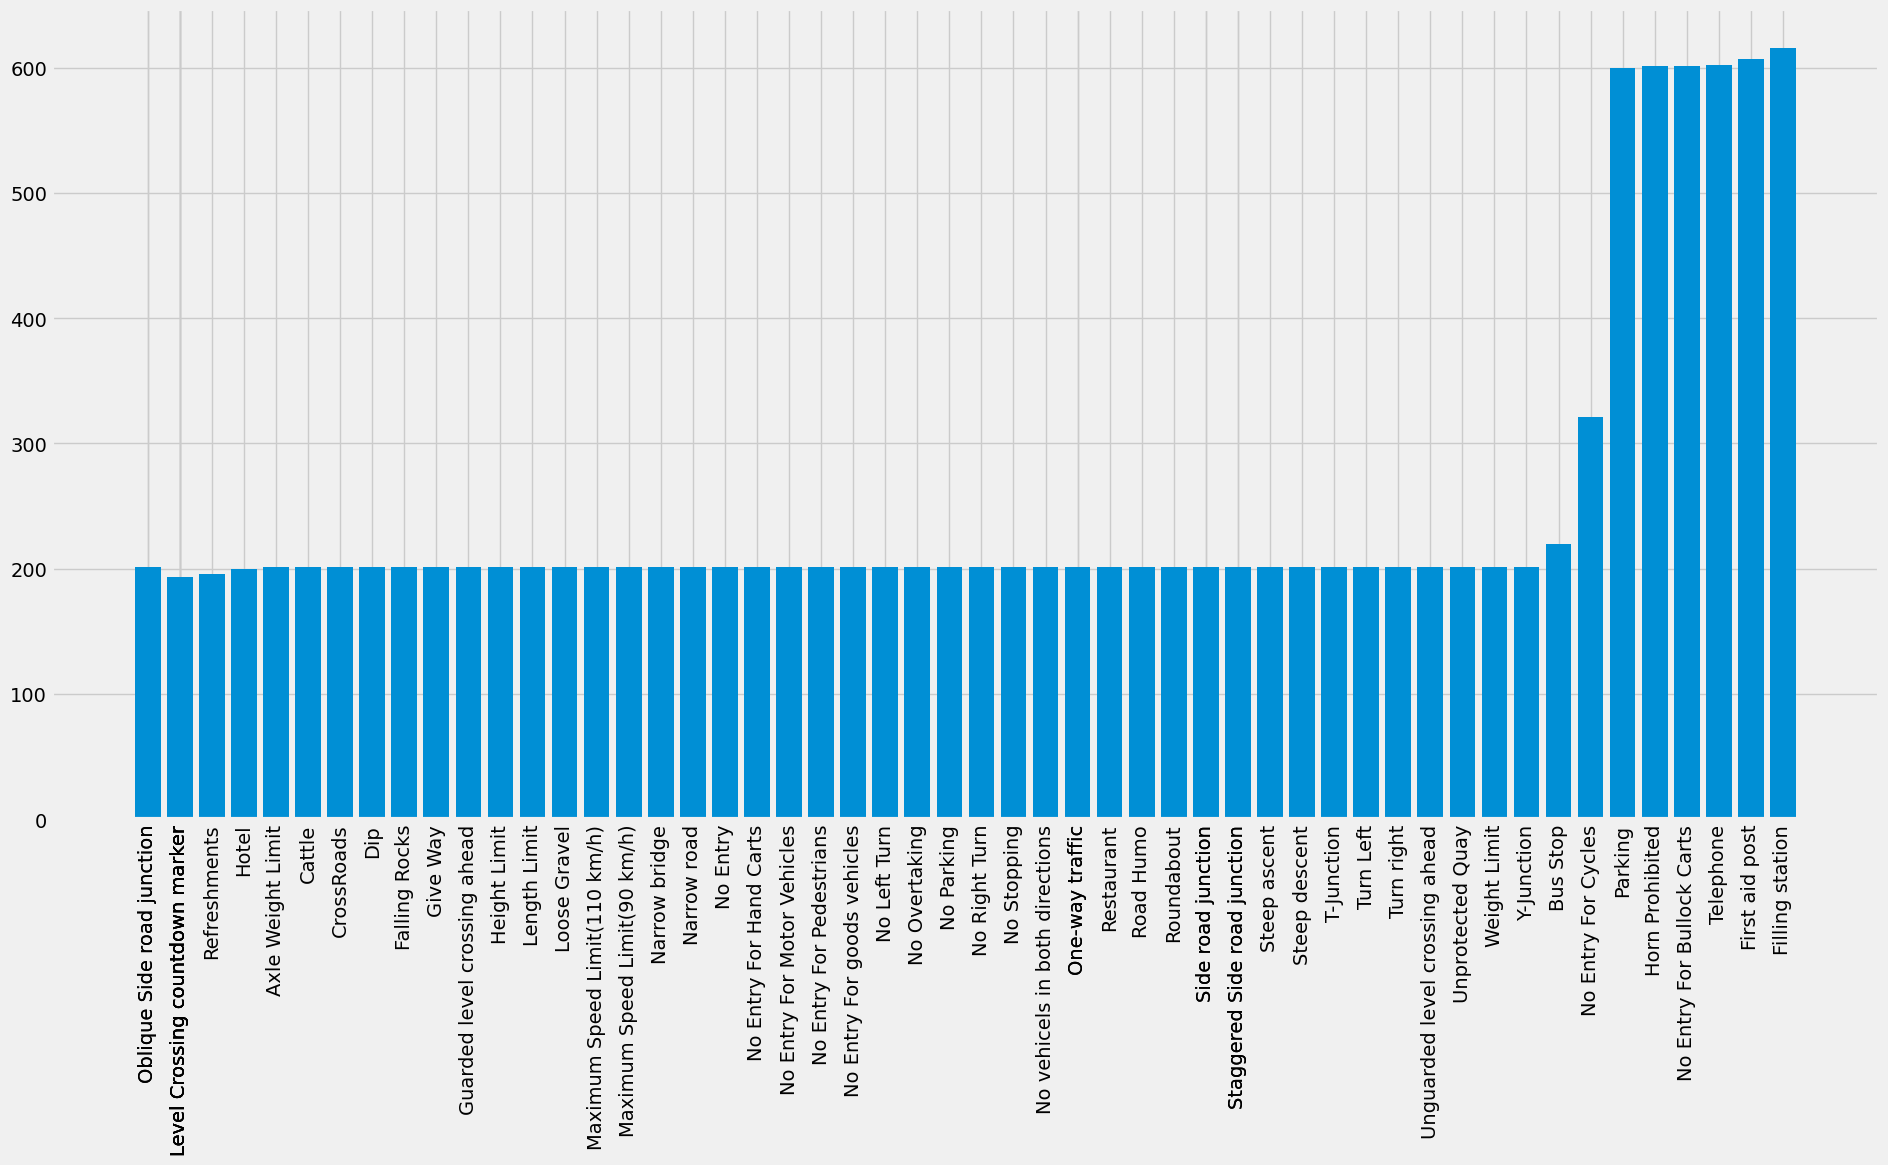

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Collecting the Training Data

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Images/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(13985, 30, 30, 3) (13985,)


## Shuffling the training data

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (9789, 30, 30, 3)
X_valid.shape (4196, 30, 30, 3)
y_train.shape (9789,)
y_valid.shape (4196,)


## One hot encoding the labels

In [ ]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(9789, 59)
(4196, 59)


## Making the model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(59, activation='softmax')
])

In [ ]:
#lr = 0.001
#epochs = 30

#opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



from tensorflow.keras.optimizers import Adam

lr = 0.001
epochs = 30

# Create the Adam optimizer with learning_rate and weight_decay
opt = Adam(learning_rate=lr, weight_decay=lr / (epochs * 0.5))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Augmenting the data and training the model

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
#compile()
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.2582 - loss: 3.3906 - val_accuracy: 0.1061 - val_loss: 4.3897
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5969 - loss: 1.4338 - val_accuracy: 0.7219 - val_loss: 0.9302
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7070 - loss: 0.9684 - val_accuracy: 0.7788 - val_loss: 0.6908
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7584 - loss: 0.7812 - val_accuracy: 0.7807 - val_loss: 0.6765
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7925 - loss: 0.6687 - val_accuracy: 0.8251 - val_loss: 0.5217
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8044 - loss: 0.6141 - val_accuracy: 0.8468 - val_loss: 0.4433
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8290 - loss: 0.5308 - val_accuracy: 0.8410 - val_loss: 0.4625
Epoch 8/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8319 - loss: 0.5236 - val_accuracy: 

In [ ]:
model.save("model.h5")

In [ ]:
model.save_weights("/content/drive/MyDrive/output.weights.h5")

In [ ]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'verti

## Evaluating the model

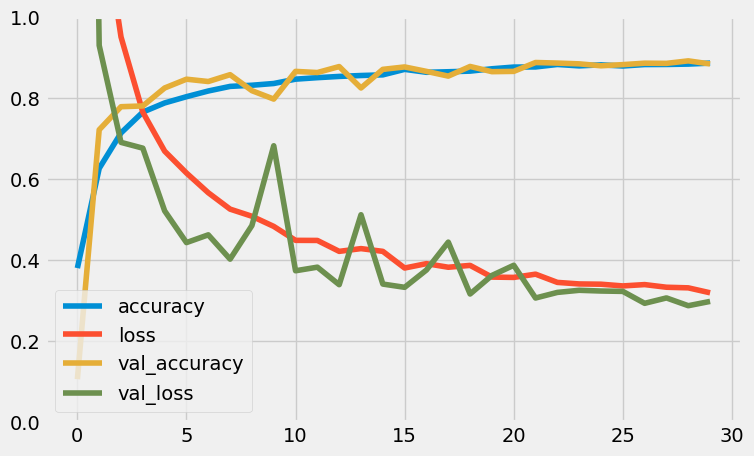

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

*   List item
*   List item



In [ ]:
#test = pd.read_csv(data_dir + '/traffic_sign.csv')

#labels = test["ClassId"].values
#imgs = test["Path"].values

#data =[]

#img = image_data # = []
#lables = image_labels #= []

#for img in imgs:
#    try:
#       image = cv2.imread(data_dir + '/' +img)
#        image_fromarray = Image.fromarray(image, 'RGB')
#        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
#        data.append(np.array(resize_image))
#    except:
#        print("Error in " + img)


image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Images/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

###############################################################

# Changing the list to numpy array
#image_data = np.array(image_data)
#image_labels = np.array(image_labels)

#print(image_data.shape, image_labels.shape)


###########################################################################

X_test = np.array(image_data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(image_labels, pred)*100)

Error in 58_original_101_original_101.png_8e12feb9-c78d-4656-889f-e4739164f282.png_64190800-71e1-42f7-9a7f-4816b0717a13.png
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Data accuracy:  91.25429061784897


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
from PIL import Image
import os

# Assuming you have the trained model loaded
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')

# Load and preprocess images
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Images/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Convert lists to numpy arrays
X_test = np.array(image_data)
X_test = X_test / 255.0  # Normalize

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(image_labels, predicted_classes) * 100
print('Test Data accuracy: {:.2f}%'.format(accuracy))


## Visualizing the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(image_labels, pred)

<Axes: >

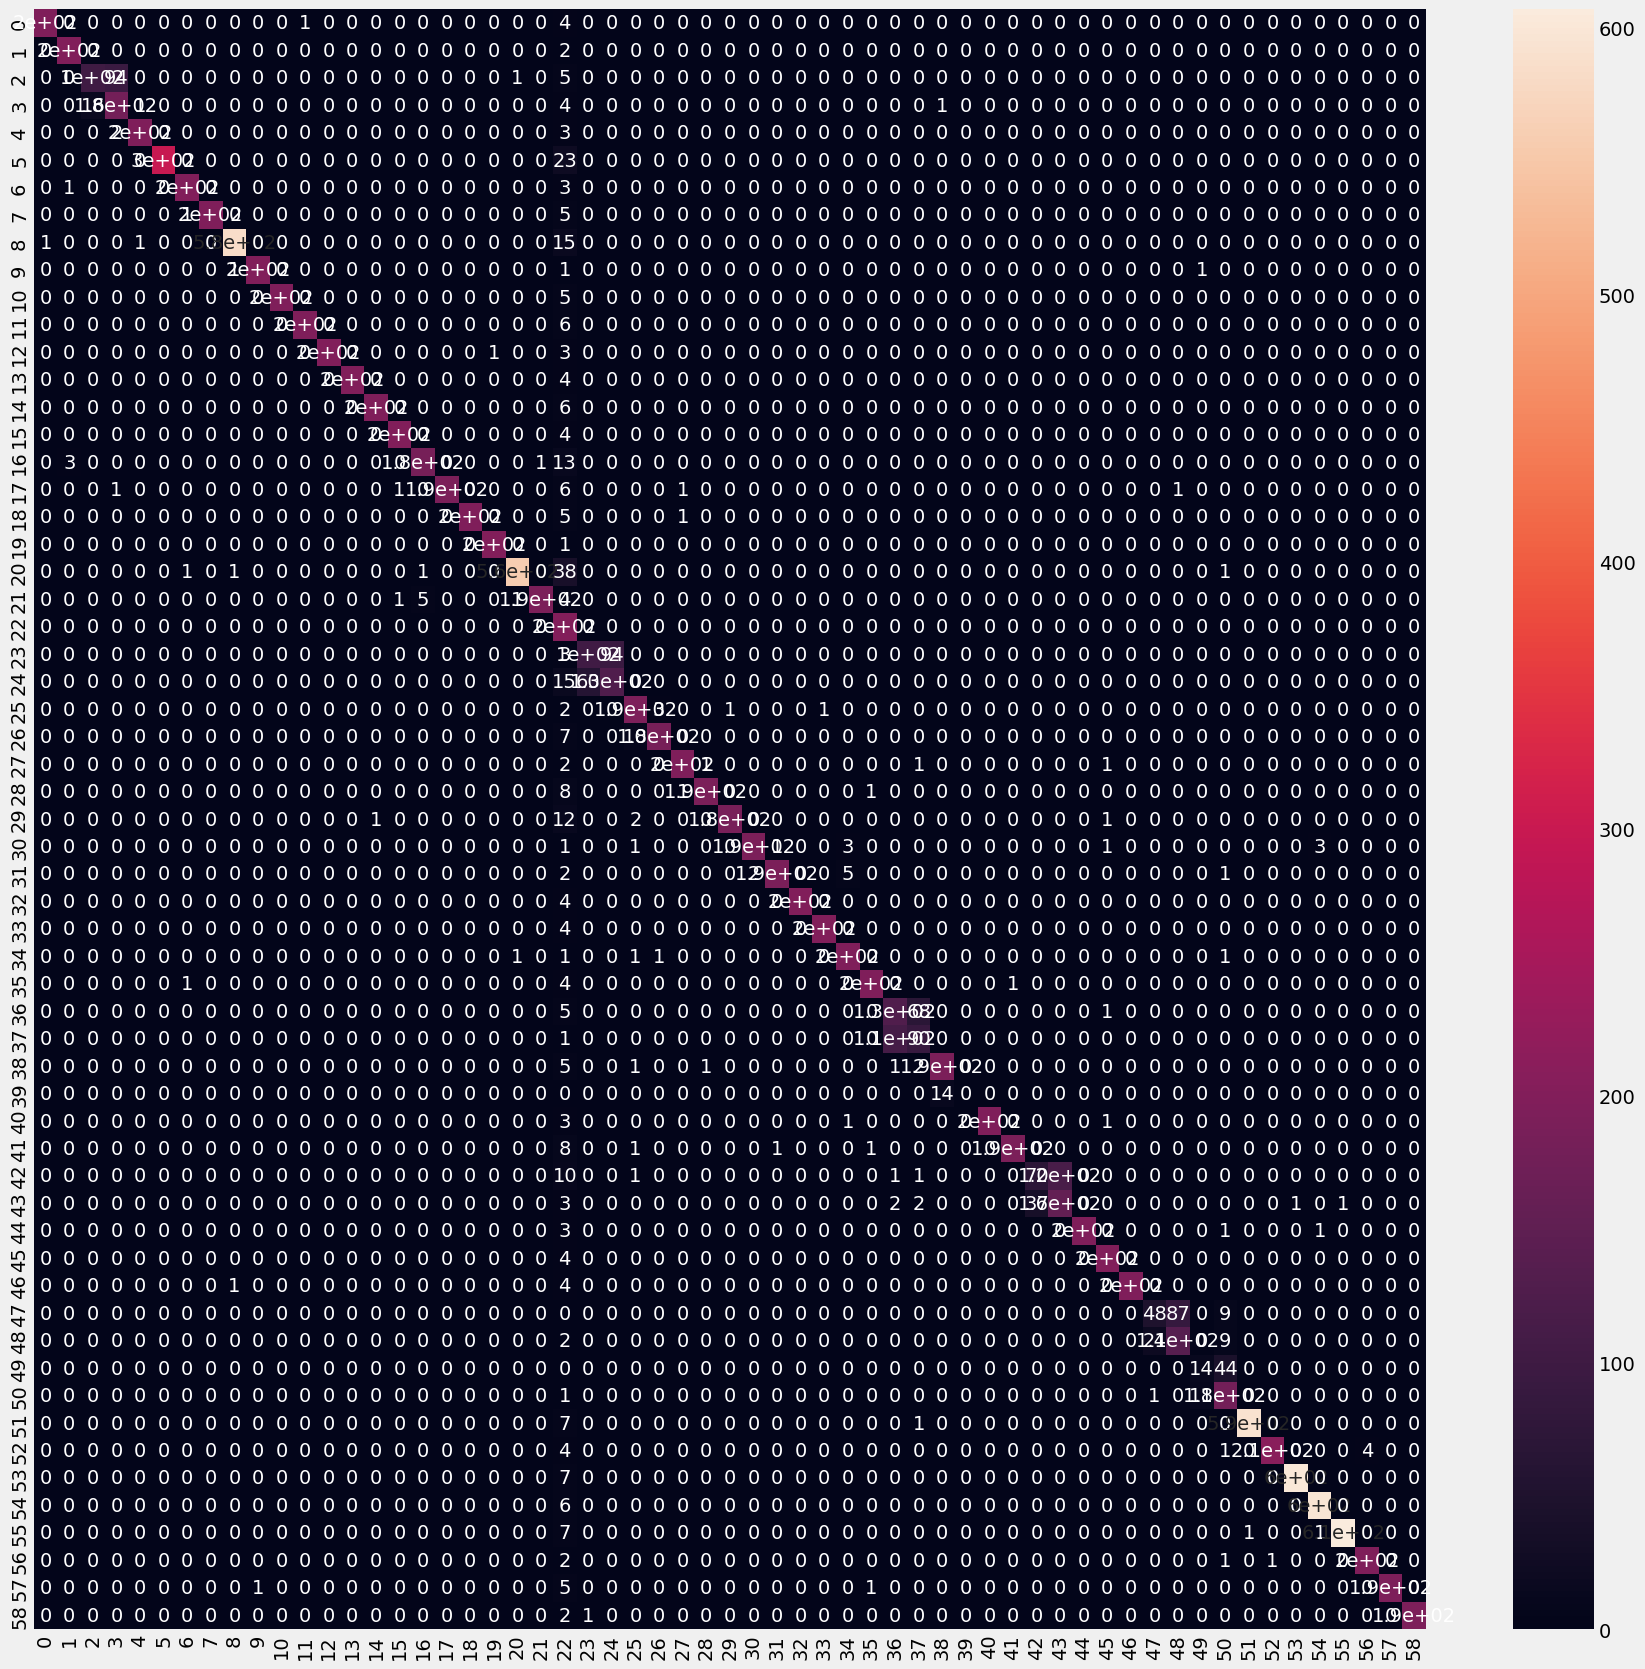

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(image_labels, pred))

## Predictions on Test Data

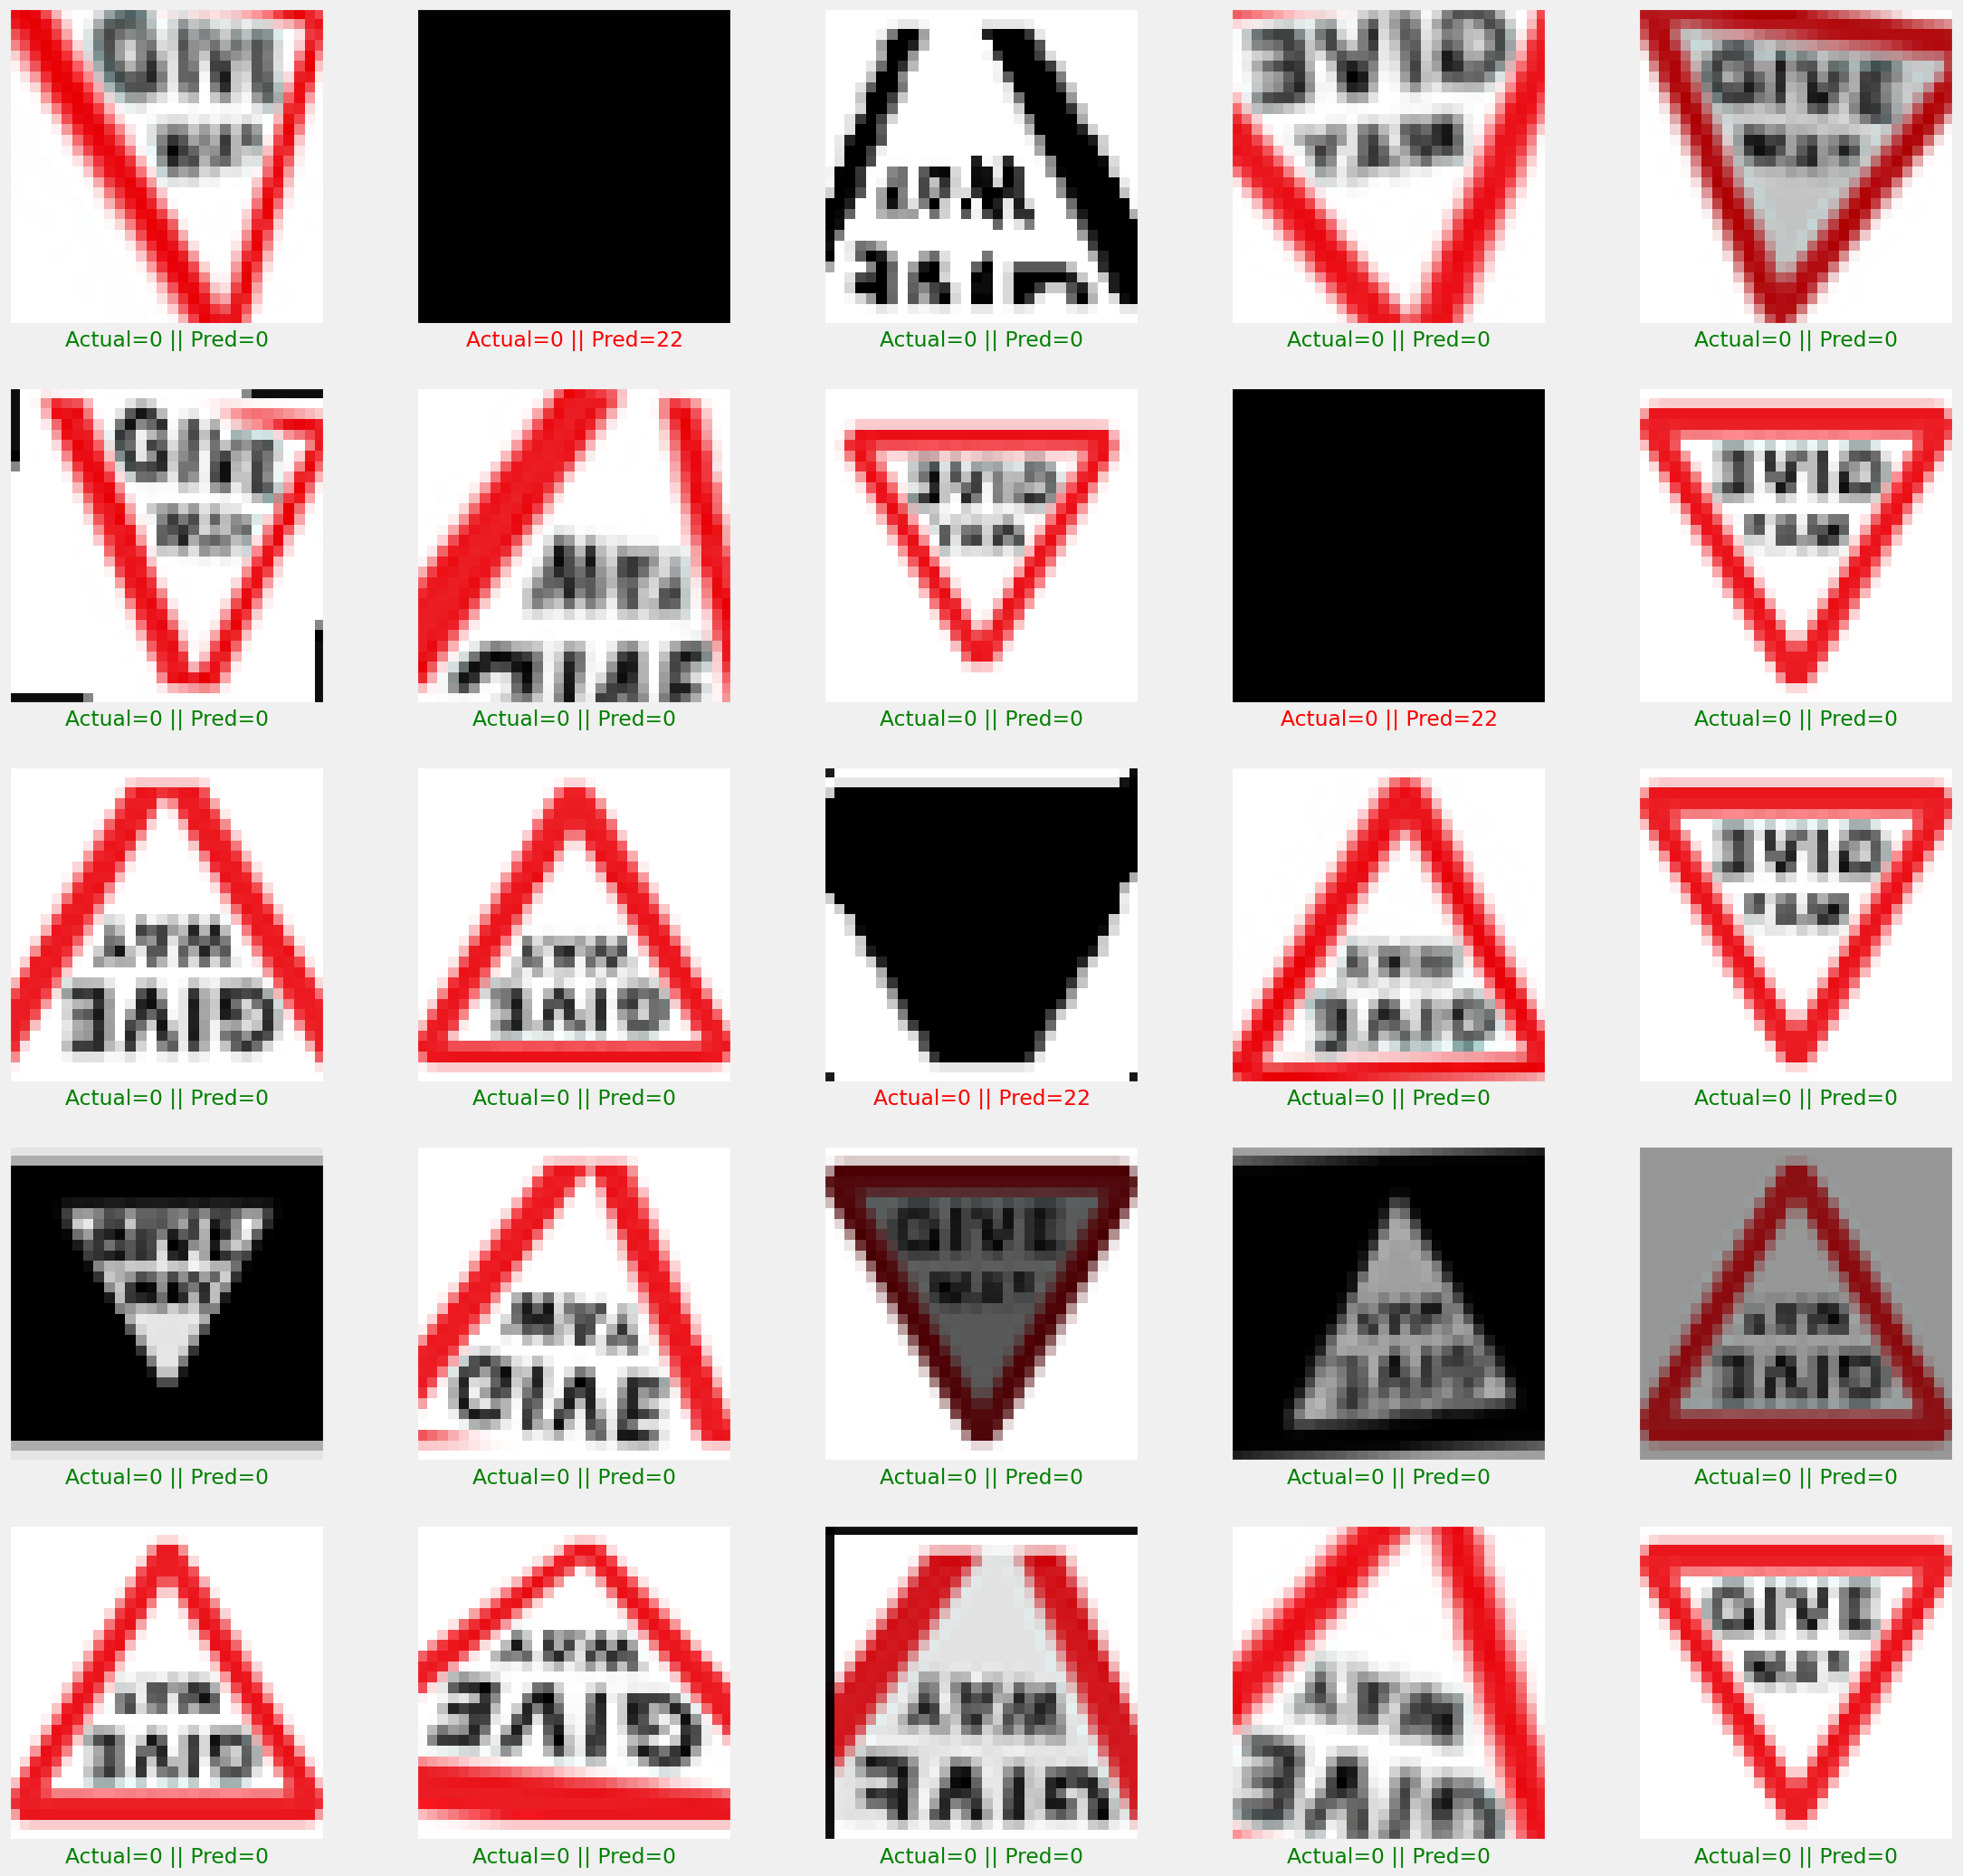

In [ ]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = predicted_classes[start_index + i]
    actual = image_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color=col)

    img = X_test[start_index + i]
    img = (img * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)

plt.show()


In [ ]:
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/test6.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
result


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


6